https://github.com/miladlink/TinyYoloV2

# Libraries

In [1]:
import os
import torch
from PIL import Image
from models.YOLOv2 import TinyYoloV2
from utils.YOLOv2 import *

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
model = 0


# Model

In [3]:
def load_model(weights=None):
    """ loading pretrainde weights to built model"""
    model = TinyYoloV2()
    if weights:
       model.load_weights(weights)
       #model.load_state_dict (torch.load (weights))
    return model.to(device)

In [4]:
# downloading pretrained weights from source
# ! wget https://pjreddie.com/media/files/yolov2-tiny-voc.weights

In [5]:
model = load_model(weights = './weights/yolov2-tiny-voc.weights')
# print(model)

# Prediction

In [6]:
# PASCAL VOC
class_names = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
               'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
               'dog', 'horse', 'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'TVmonitor'] 


In [7]:
def predict(model, img_path, save_to=None):
    assert os.path.exists(img_path), 'Error! Input image does not exists.'
    model.eval()
    img = Image.open(img_path).convert('RGB')
    print(ToTensor(img).shape)
 
    tic = time.time()
    # finding and filtering boxes
    boxes = filtered_boxes(model, img.resize((416, 416)), conf_thresh=0.66, nms_thresh=0.55, device=device)
    # print(boxes)
 
    toc = time.time()
    print('Prediction took {:.5f} ms.'.format((toc - tic) * 1000))
    # visualize image and bboxes
    pred_img = plot_boxes(img, boxes, save_to, class_names)
    
    return pred_img

torch.Size([1, 3, 333, 500])
Prediction took 251.32585 ms.


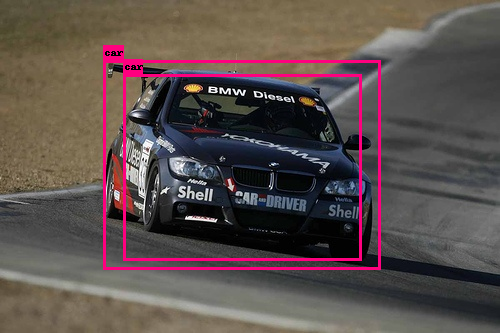

In [8]:
predict(model, './data/VOC2007/JPEGImages/009729.jpg')

# COCO loader

In [9]:
import torchvision.transforms as transforms
from torchvision.datasets import CocoDetection
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt


create dataset

In [10]:
# root = "./data/COCO2017/val2017"
# annFile = "./data/COCO2017/annotations/instances_val2017.json"
root = "./data/VOC2007/JPEGImages"
annFile = "./data/VOC2007/annotations/val.json"
transform = transforms.Compose([
    transforms.ToTensor(),
])
coco_dataset = CocoDetection(root=root, annFile=annFile, transform=transform)

loading annotations into memory...
Done (t=0.64s)
creating index...
index created!


create dataloader

In [11]:
import torch
from torch.utils.data import DataLoader

# Define batch size
batch_size = 32

def collate_fn(batch):
    return tuple(zip(*batch))

# Create a DataLoader for your COCO dataset
train_loader = DataLoader(coco_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(coco_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

In [12]:
def xyxy2xywh(x):
    # Convert nx4 boxes from [x1, y1, x2, y2] to [x, y, w, h] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[..., 0] = (x[..., 0] + x[..., 2]) / 2  # x center
    y[..., 1] = (x[..., 1] + x[..., 3]) / 2  # y center
    y[..., 2] = x[..., 2] - x[..., 0]  # width
    y[..., 3] = x[..., 3] - x[..., 1]  # height
    return y

def xywh2xyxy(x):
    # Convert nx4 boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[..., 0] = x[..., 0] - x[..., 2] / 2  # top left x
    y[..., 1] = x[..., 1] - x[..., 3] / 2  # top left y
    y[..., 2] = x[..., 0] + x[..., 2] / 2  # bottom right x
    y[..., 3] = x[..., 1] + x[..., 3] / 2  # bottom right y
    return y

inference and output json file containing prediction

In [26]:
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from pycocotools.coco import COCO
import json
import cv2
from tqdm import tqdm
import numpy as np
from detect import detect_image
from models.YOLOv3 import load_model
from utils.utils import load_classes, rescale_boxes, non_max_suppression, print_environment_info
from utils.transforms import Resize, DEFAULT_TRANSFORMS

predictions = []
modelv = 2
img_size=416

if modelv == 3: # YOLOv3
    model = load_model("./config/yolov3.cfg", "./weights/yolov3.weights")
     # COCO
    class_names = ['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
    id_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90]

for i, data in enumerate(tqdm(val_loader)): # * ASSUME ONE IMAGE PER BATCH
    images, targets = data
    with torch.no_grad():
        try:
            model.eval()
            # for target in targets[0]: print(f"id {target['image_id']}, class {target['category_id']}, bbox {target['bbox']}")
            image_id = targets[0][0]["image_id"]
            category_id = targets[0][0]["category_id"]
            img = images[0].unsqueeze(0).to(device)
            img_copy = img.clone().detach()
            # print(img.shape) # torch.Size([1, 3, 375, 500])

            # imageN = img.clone().detach()
            # imageN = imageN.cpu().squeeze().permute(1, 2, 0).numpy() # * just for sanity check, output image. put the dim 3 at the back
            # imageN = cv2.cvtColor(imageN, cv2.COLOR_RGB2BGR)
            # # print(imageN.shape)
            # cv2.imwrite("output/mygraph.jpg", imageN*255) 

            if modelv == 2:
                resized_tensor_image = torch.nn.functional.interpolate(img, size=(416, 416), mode='bilinear', align_corners=False)
                # print(resized_tensor_image.shape)
                # * default 0.66, 0.55, higher conf -> more strict, higher nms -> more iou needed -> more strict
                boxes = filtered_boxes(model, resized_tensor_image, conf_thresh=0.5, nms_thresh=0.7, device=device)
            elif modelv == 3:
                img = img.cpu().squeeze().permute(1, 2, 0).numpy()
                img = transforms.Compose([DEFAULT_TRANSFORMS, Resize(img_size)])((img, np.zeros((1, 5))))[0].unsqueeze(0).to(device)
                boxes = model(img)
                boxes = non_max_suppression(boxes, conf_thres=0.3, iou_thres=0.5)[0].numpy()
                # print(boxes.shape, img_size, og_shape[2:])
                # print(boxes)
                
                boxes = rescale_boxes(boxes, img_size, img_copy.shape[2:]) # rescale back to original proportions?
                boxes = xyxy2xywh(boxes) # convert from coco to yolo
                boxes[:,0] = boxes[:,0]/img_copy.shape[3]
                boxes[:,1] = boxes[:,1]/img_copy.shape[2]
                boxes[:,2] = boxes[:,2]/img_copy.shape[3]
                boxes[:,3] = boxes[:,3]/img_copy.shape[2]
                
                boxes = np.concatenate((boxes[:, :5], boxes[:, 4:5], boxes[:, 5:]), axis=1)
                boxes[:, 6] = boxes[:, 6].astype(int)
            else: 
                print("invalid model num!")
            
            # put into coco format of x_min,y_min, width, height, bbox_conf, cls
            # yolo format is x_center, y_center, w, h, bbox_conf, cls_conf, cls
            
            # to_pil = transforms.ToPILImage() # * another sanity check
            # pil_image = to_pil(img_copy.squeeze())
            # pred_img = plot_boxes(pil_image, boxes, None, class_names)
            # pil_image.save("./output/path_to_save_image.jpg")
            
            for box in boxes:
                x_center, y_center, w, h, bbox_conf, cls_conf, cls = box
                x_min = max(0, (x_center - w / 2) * img_copy.shape[3])
                y_min = max(0, (y_center - h / 2) * img_copy.shape[2])
                width = min(img_copy.shape[3], w * img_copy.shape[3])
                height = min(img_copy.shape[2], h * img_copy.shape[2])
                # print(x_min,y_min, width, height, bbox_conf, cls)
                predictions.append({
                    'image_id': image_id,
                    'category_id': id_list[int(cls)],
                    'bbox': [int(x_min), int(y_min), int(width), int(height)],
                    'score': round(float(bbox_conf),2)
                })
            
 
        except:
            # break
            continue
            # print("error", targets) # pics without labels
    # break

# print(predictions)

with open('./data/results/v2predictions.json', 'w') as f:
    json.dump(predictions, f)

 14%|█▍        | 720/5000 [00:15<01:23, 51.45it/s]

compare gt and prediction

install cocoapi: pip install git+https://github.com/philferriere/cocoapi.git#subdirectory=PythonAPI

C:\Users\anton\anaconda3\Lib\site-packages\pycocotools\cocoeval.py

issue #1: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.

fix: https://github.com/cocodataset/cocoapi/issues/356 at line 507,508, 518, 519

https://github.com/cocodataset/cocoapi/pull/354/commits/6c3b394c07aed33fd83784a8bf8798059a1e9ae4#diff-b13be02996507277fdef1503fc74ab7ac7679a15450b60982222f8ca051bc8ee

issue #2: module 'numpy' has no attribute 'float'

fix: changed x.astype(float) in line 379,380 of cocoeval.py to np.float64(x)

In [25]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# coco_gld = COCO('./data/COCO2017/annotations/instances_val2017.json') # coco
# coco_rst = coco_gld.loadRes('./data/results/v3predictions_30_50.json')
coco_gld = COCO('./data/COCO2017/annotations/instances_val2017.json') # pascal
coco_rst = coco_gld.loadRes('./data/results/predictions.json')
cocoEval = COCOeval(coco_gld, coco_rst, iouType='bbox')
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

loading annotations into memory...
Done (t=0.47s)
creating index...
index created!
Loading and preparing results...
DONE (t=2.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=38.18s).
Accumulating evaluation results...
DONE (t=5.86s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.667
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.375
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.413
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.549
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.300
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.468
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet